# 1. Importing Necessary Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
import os
import random
%matplotlib inline
random.seed(42)
plt.rcParams.update({'font.size': 25})
sns.set_theme(color_codes=True)
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/smartphone-human-fall-dataset/Train.csv
/kaggle/input/smartphone-human-fall-dataset/Test.csv


# 2. Loading the Datasets

In [2]:
train_df = pd.read_csv("../input/smartphone-human-fall-dataset/Train.csv")
test_df = pd.read_csv('../input/smartphone-human-fall-dataset/Test.csv')

In [3]:
train_df.head()

,Unnamed: 0,acc_max,gyro_max,acc_kurtosis,gyro_kurtosis,label,lin_max,acc_skewness,gyro_skewness,post_gyro_max,post_lin_max,fall
0,661,26.039919,7.309797,20.378162,2.782476,SDL,11.131080,3.891361,1.592927,7.086618,10.790400,1
1,122,25.864500,6.511954,14.187190,5.324864,FOL,7.945561,3.022175,2.376939,6.325522,7.719352,1
2,113,27.524501,12.944099,31.855926,22.891186,FOL,14.454818,4.849024,4.283890,12.888111,14.368784,1
3,14,30.647705,11.694868,23.608764,9.287735,FOL,15.228303,3.921537,2.794609,11.549971,14.944151,1
4,529,26.373917,11.168424,14.318453,15.983202,FKL,10.007396,3.087975,3.363557,11.057636,9.753058,1


In [4]:
test_df.head()

,Unnamed: 0,acc_max,gyro_max,acc_kurtosis,gyro_kurtosis,label,lin_max,acc_skewness,gyro_skewness,post_gyro_max,post_lin_max,fall
0,9,28.055199,10.794617,21.334536,34.163811,FOL,13.880578,3.283404,4.577283,10.755339,13.762561,1
1,11,26.639681,8.785024,13.518671,12.812894,FOL,15.789372,3.301849,3.464729,8.277714,15.341656,1
2,19,25.045219,5.307413,21.603060,4.754182,FOL,11.592445,3.124714,2.268676,4.976134,11.303823,1
3,23,24.102184,8.929061,24.647657,18.595684,FOL,10.107835,4.522305,3.955288,8.719755,9.727437,1
4,28,31.668808,10.714750,18.008912,15.086251,FOL,14.138265,3.142132,3.530621,10.580791,13.935016,1


In [5]:
train_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [6]:
print(f"Training data shape: {train_df.shape}\nTest data shape: {test_df.shape}")

Training data shape: (1428, 11)
Test data shape: (356, 11)


In [7]:
X_train = train_df.drop(['fall','label'],axis=1)
y_train = train_df['fall']
X_test =  test_df.drop(['fall','label'],axis=1)
y_test =  test_df['fall']

# 3. Similarity Measure and Feature Selection

In [8]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train)

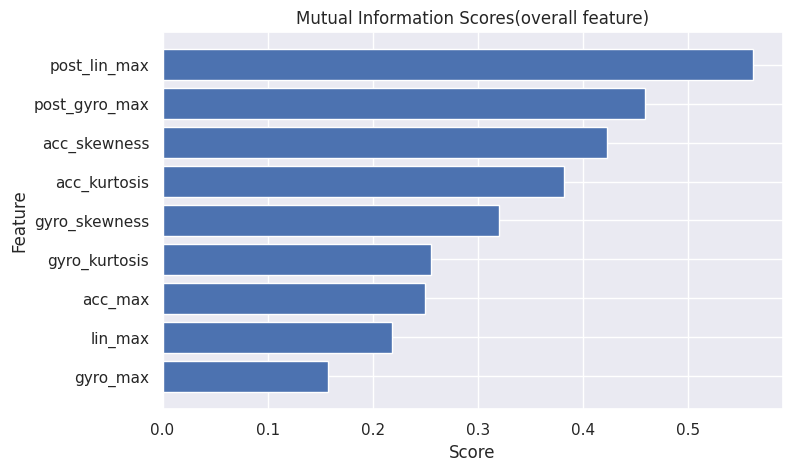

In [9]:
def plot_utility_scores(scores):
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.barh(width, y)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores(overall feature)")

plt.figure(dpi=100, figsize=(8, 5))
plt.xlabel("Score")
plt.ylabel("Feature")
plot_utility_scores(mi_scores)

<AxesSubplot:>

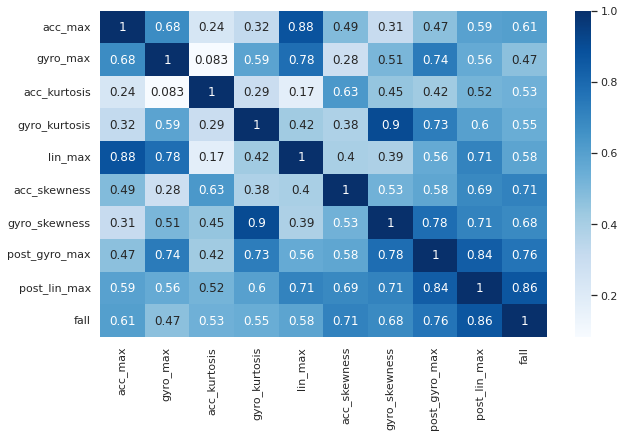

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(train_df.corr(), ax=ax,  cmap="Blues", annot=True)

In [11]:
X_train.drop(['gyro_max'], axis=1, inplace=True)
X_test.drop(['gyro_max'], axis=1, inplace=True)

<AxesSubplot:xlabel='label', ylabel='post_gyro_max'>

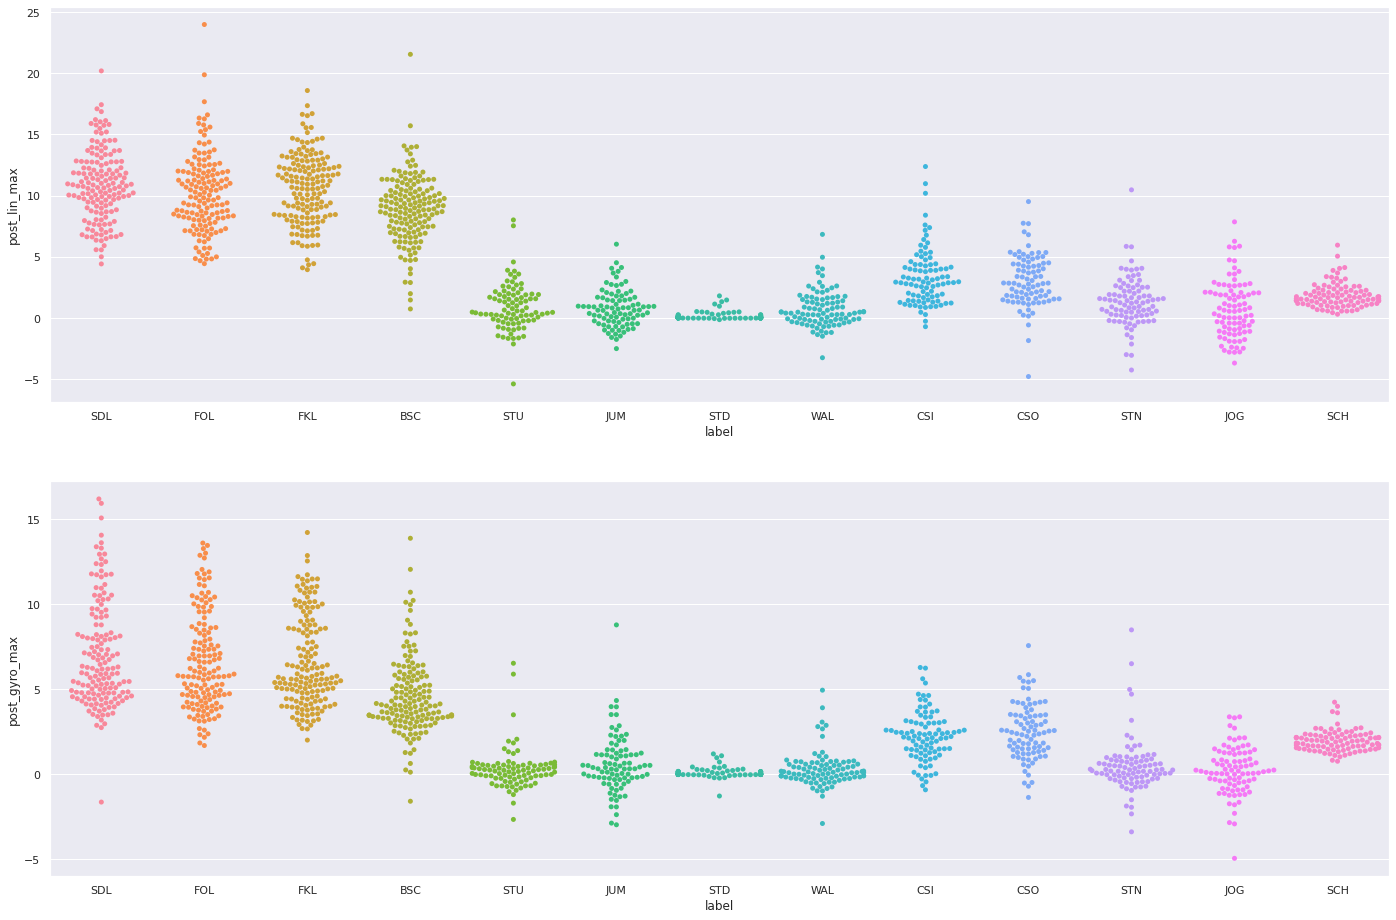

In [12]:
figure, ax = plt.subplots(2, figsize=(24, 16))

sns.swarmplot(x = train_df.label,y = train_df.post_lin_max, ax = ax[0])
sns.swarmplot(x = train_df.label,y = train_df.post_gyro_max, ax = ax[1])

# 4. Feature Normalization

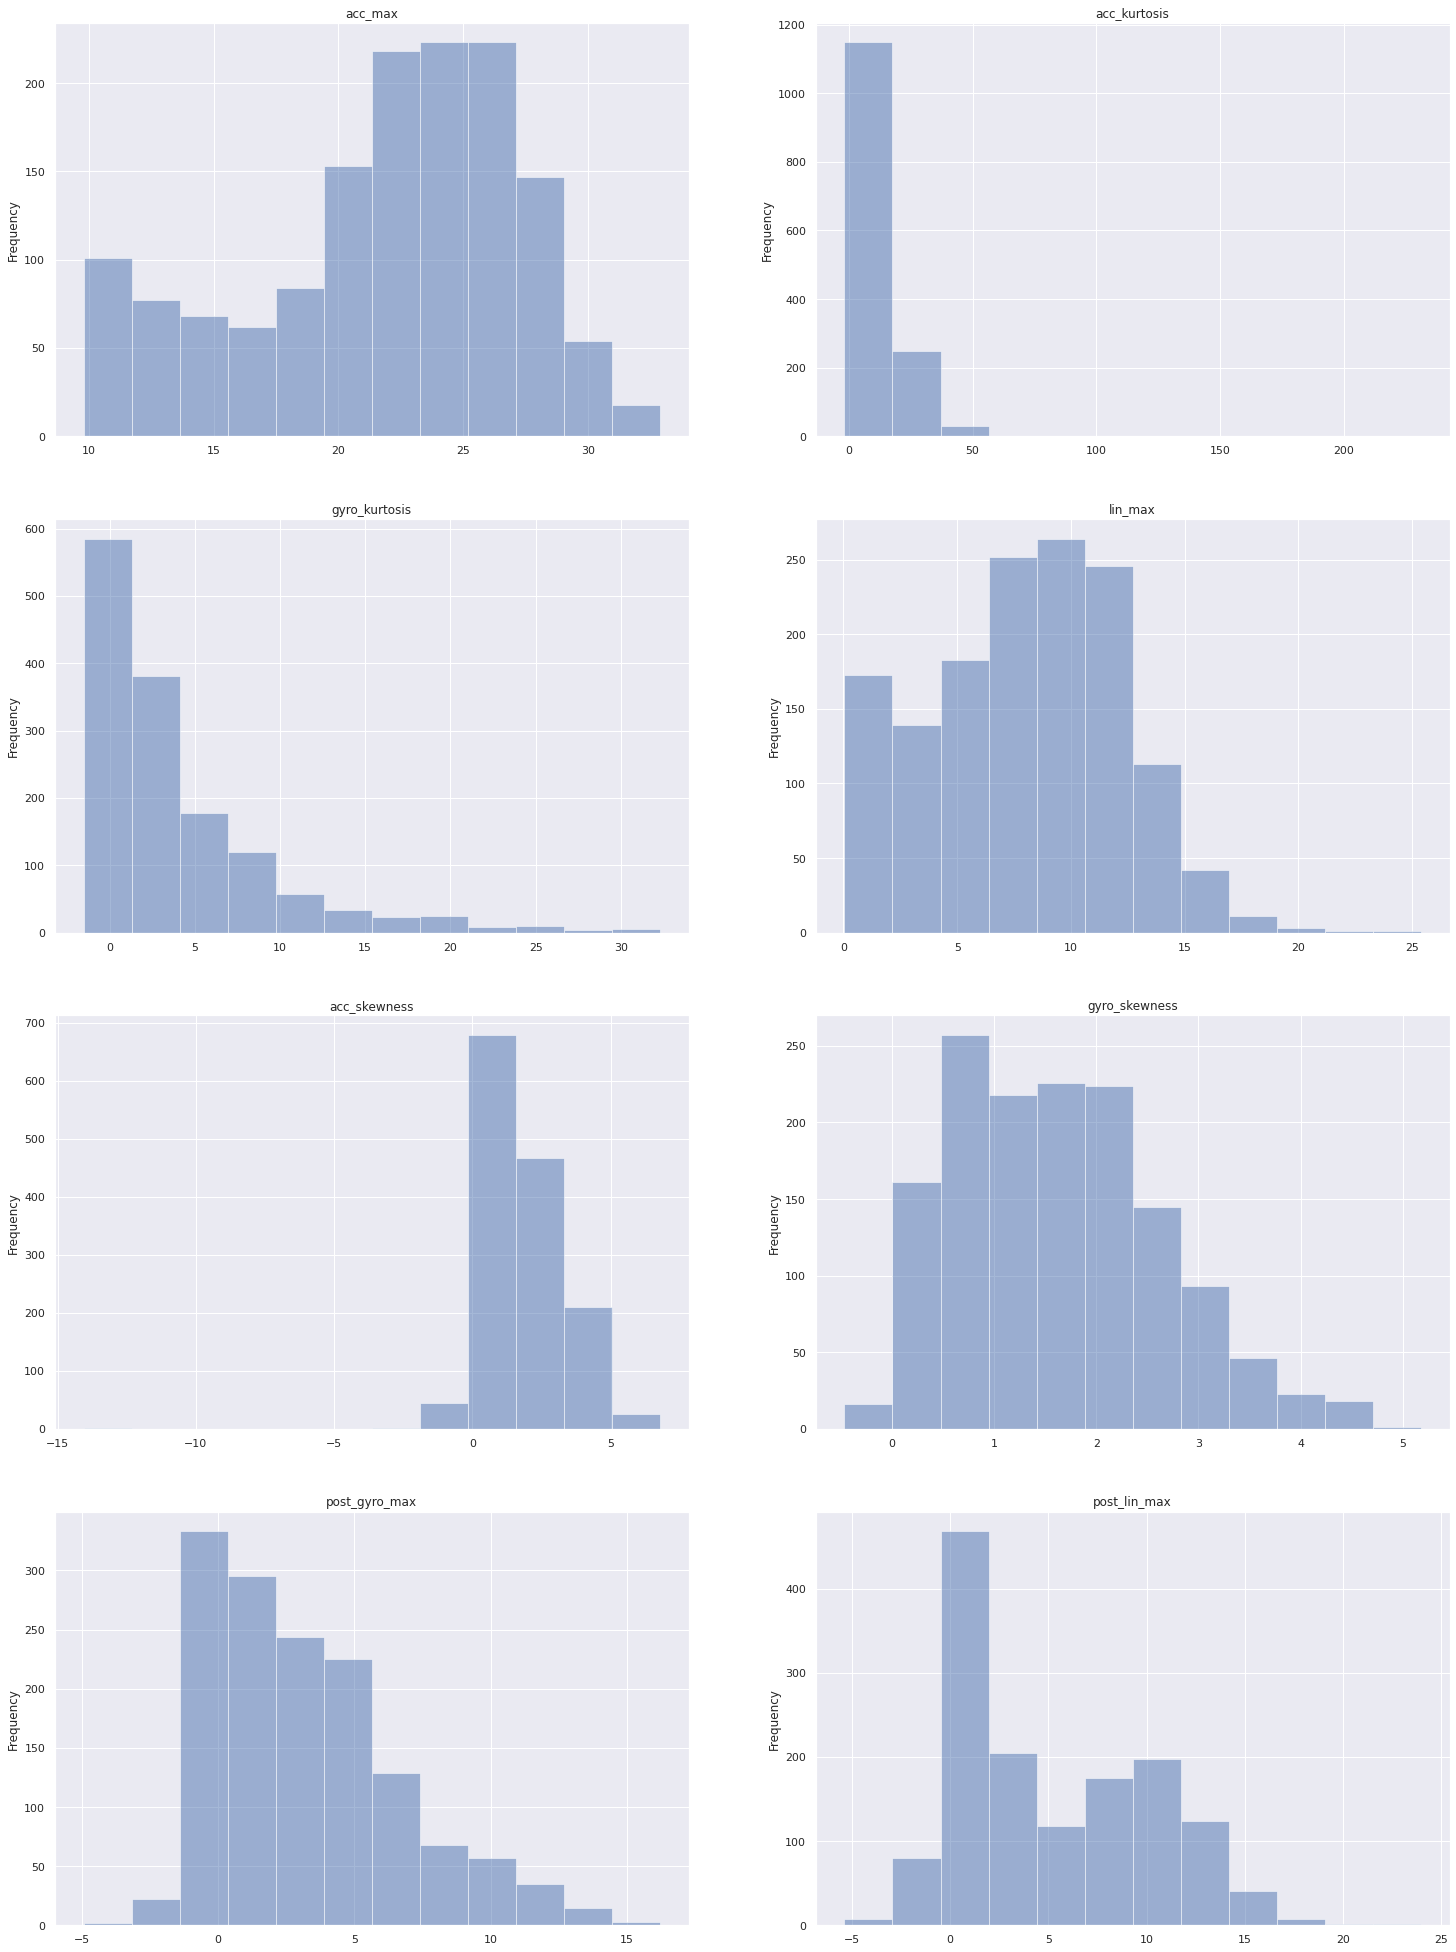

In [13]:
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
figure, ax = plt.subplots(4,2, figsize=(25, 35))
i=0
j=0
for col in X_train.columns:
    ax[j][i].title.set_text(col)
    X_train[col].plot.hist(bins=12, alpha=0.5, ax = ax[j][i])
    i+=1
    if(i%2==0):
        j+=1
        i =0

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 5. Hyperparameter Tuning of Random Forest using Random Search

In [15]:
# Number of trees in random forest
n_estimators = [200,400,600,800,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [None,10,30,50,70]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 9, 12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5, 7]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [None, 10, 30, 50, 70], 'min_samples_split': [2, 5, 9, 12], 'min_samples_leaf': [1, 3, 5, 7], 'bootstrap': [True, False]}


In [16]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100, cv = 5,
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1
                              )
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=9, n_estimators=1000; total time=   3.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 30, 50, 70],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7],
                                        'min_samples_split': [2, 5, 9, 12],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42, verbose=2)

In [17]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [18]:
# Creating a function to evaluate our model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = (((predictions==test_labels).sum())/test_labels.shape[0])*100
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [19]:
best_estimator = rf_random.best_estimator_
optimal_accuracy = evaluate(best_estimator, X_test, y_test)

Model Performance
Accuracy = 97.47%.


In [25]:
X_test

array([[ 1.15041235,  0.94879958,  5.50766259, ...,  2.95343321,
         2.19231136,  1.71787736],
       [ 0.89200484,  0.29658289,  1.62124884, ...,  1.84005078,
         1.47026829,  2.03432099],
       [ 0.60093051,  0.9712073 ,  0.15435692, ...,  0.64310599,
         0.5081034 ,  1.2251572 ],
       ...,
       [ 0.03594548, -0.7326274 , -0.81728803, ..., -1.22250661,
        -1.00245556, -0.81083338],
       [ 0.50217496, -0.88691557, -0.81351606, ..., -1.31388745,
        -0.63372261, -0.16077785],
       [ 0.41981185, -0.71330284, -0.83665911, ..., -1.35407403,
        -1.03001573, -0.51385344]])


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=7, min_samples_split=9, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=9, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=7, min_samples_split=5, n_estimators=600; total time=   2.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=7, min_samples_split=5, n_estimators=600; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=1000; total time=   3.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=7, min_samples_split=9, n_estimators=1000; total time=   3.6s
[CV] END bootstrap=False, max_depth=None, 

In [20]:
params = rf_random.best_params_

min_split = [ 2, 4, 6, 8,12]
min_samples_leaf = [1, 2, 3, 4, 5]

x = []
y = []
acc = []
highest_accuracy = 0

for split in min_split:
    params['min_samples_split'] = split
    for leaf in min_samples_leaf:
        params['min_samples_leaf'] = leaf
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        accuracy = evaluate(model, X_test, y_test)
        acc.append(accuracy)
        x.append(split)
        y.append(leaf)
        highest_accuracy = max(highest_accuracy,accuracy)

Model Performance
Accuracy = 96.91%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 96.91%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 96.91%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.47%.
Model Performance
Accuracy = 97.19%.
Model Performance
Accuracy = 97.19%.


In [21]:
print(f"The highest accuracy obtained is: {highest_accuracy}%.")       

The highest accuracy obtained is: 97.47191011235955%.


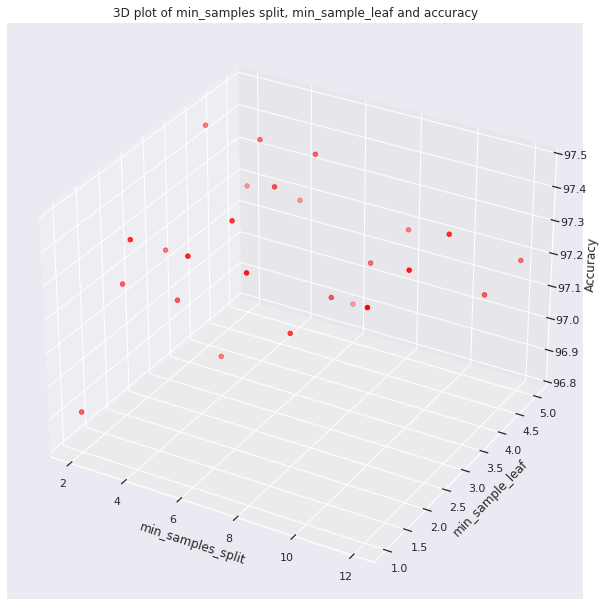

In [22]:
#%matplotlib widget
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,8))
ax = Axes3D(fig)
accuracy_plot = ax.scatter(x, y, acc, color='red', cmap='Blues')
  
# setting title and labels
ax.set_title("3D plot of min_samples split, min_sample_leaf and accuracy")
ax.set_xlabel('min_samples_split')
ax.set_ylabel('min_sample_leaf')
ax.set_zlabel('Accuracy')
ax.set_zlim(96.8,97.5)
plt.show()

In [26]:
import joblib
joblib.dump(best_estimator, "./random_forest.joblib")

['./random_forest.joblib']

In [28]:
loaded_rf = joblib.load("./random_forest.joblib")
optimal_accuracy = evaluate(loaded_rf, X_test, y_test)

Model Performance
Accuracy = 97.47%.
